### Find the theoretical contribution from the reflected path
# $E(r) = \frac{1}{r} \times cos^2(\theta) \times Fresnel\_coefficients(90°-\theta)$
- $\frac{1}{r}$ is the distance factor
- $cos^2(\theta)$ is an approximate beam pattern factor
- $Fresnel\_coefficients(90°-\theta)$ is the reflection coefficient for the given angle

~~~
_________________________________________________________
    |                       |                       |
    |                  R   / \                      |
    |                 e     |                       |
    |                f   /     \                    |
    |               l       |                       |
    |              e   /         \                  |
    |             c         |                       |
    |            t   /             \                |
    |           e           |                       |
    |          d   /                 \              |
    |                       | 90-Θ  /              |
    |            /                 /   \            |
    |                       |___-`                  |
    |          /                         \          |
    |                       |                       |
    |        /                             \        |
    |                       |                       |
    |      /                                 \      |
    |                       |                       |
    |    /                                     \    |
    |                       |                       |
    |  /                                       --\  |
    |                       |___             /      |
    |/                          |           /  Θ   \|
   RX _  _  _  _  _  _  _  _|_ _| _  _  _  _| _  _  TX
        <- Direct Path
~~~


Fresnel coefficients:
- For VPol (perpendicular):
    - ## $r_{\perp} = \frac{n_1 \cos(\theta_i) - n_2 \cos(\theta_t)}{n_1 \cos(\theta_i) + n_2 \cos(\theta_t)}$
        - $r$ is the reflection coefficient
    - ## $t_{\perp} = \frac{2 n_1 \cos(\theta_i)}{n_1 \cos(\theta_i) + n_2 \cos(\theta_t)}$
        - $t$ is the transmission coefficient
- For HPol (parallel):
    - ## $r_{\parallel} = \frac{n_2 \cos(\theta_i) - n_1 \cos(\theta_t)}{n_2 \cos(\theta_i) + n_1 \cos(\theta_t)}$
    - ## $t_{\parallel} = \frac{2 n_1 \cos(\theta_i)}{n_2 \cos(\theta_i) + n_1 \cos(\theta_t)}$
- where:
    - $\theta_i$ is the angle of incidence (angle between the incident ray and the normal)
    - $\theta_t$ is the angle of transmission (angle between the transmitted ray and the normal)
    - $n_1$ is the refractive index of the first medium (air, n=1)
    - $n_2$ is the refractive index of the second medium (ice, n=1.73)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

distance = 34.63  # m, distance between TX and RX
depths = np.arange(1, 56, 1)  # m, depth of the TX [1, 55] m

In [2]:
def incidence_angle_from_normal(depth, L):
    # angle at the surface w.r.t. the normal
    return np.arctan2(L, 2*depth)

def fresnel_reflection_coeff(theta_i, pol, n1=1.73, n2=1.0):
    # theta_i: incidence angle from the surface normal (in radians)
    # Returns complex reflection coefficient r (include phase; |r|<=1, =1 under TIR)
    # sin_t = (n1/n2) * np.sin(theta_i)
    sin_t = np.sin(theta_i)
    # allow complex for TIR region
    cos_t = np.sqrt(1.0 - sin_t**2 + 0j)  #

    cos_i = np.cos(theta_i)

    if pol == 'HPol':  # TE / s
        r = (n1*cos_i - n2*cos_t) / (n1*cos_i + n2*cos_t)
    elif pol == 'VPol':  # TM / p
        r = (n2*cos_i - n1*cos_t) / (n2*cos_i + n1*cos_t)
    else:
        raise ValueError("pol must be 'HPol' or 'VPol'")
    return r

def reflected_field(depth, L, pol, n1=1.73, n2=1.0,
                    Gtx=lambda th: 1.0, Grx=lambda th: 1.0):
    """
    Complex E-field for the reflected path.
    k = 2π/λ in ice (if None, returns amplitude without propagation phase).
    Gtx, Grx: antenna gain (field) patterns vs. angle relative to boresight (user-defined).
    """

    # E(r) = 1/r x cos^2(theta) Fres_Coeff(90-theta)
    # distance factor
    # r_refl = np.sqrt(L**2 + (2*depth)**2)  # reflected path length
    r_refl = 2 * np.sqrt((L / 2)**2 + depth**2)  # reflected path length
    theta_i = incidence_angle_from_normal(depth, L)  # angle at interface
    d_factor = 1 / r_refl

    # beam pattern factor (approximate)
    beam_factor = np.cos(theta_i)**2

    # Fresnel coefficient
    if pol == 'VPol':
        fresnel_coeff = abs((n1 * np.cos(np.pi/2 - theta_i) - n2 * np.cos(theta_i)) /
                            (n1 * np.cos(np.pi/2 - theta_i) + n2 * np.cos(theta_i)))
    elif pol == 'HPol':
        fresnel_coeff = abs((n2 * np.cos(np.pi/2 - theta_i) - n1 * np.cos(theta_i)) /
                            (n2 * np.cos(np.pi/2 - theta_i) + n1 * np.cos(theta_i)))
    else:
        raise ValueError("pol must be 'HPol' or 'VPol'")

    return d_factor * beam_factor * fresnel_coeff, theta_i, r_refl

def direct_field(distance):
    """ Calculate the electric field magnitude of the direct path given the distance r
    using the formula:
    E(r) = 1/r
    """
    return 1 / distance

In [18]:
d = 34.63
depths = np.arange(0, 56, 5)  # m, depth of the TX [1, 55] m
# depths = np.arange(35, 45, .5)  # m, depth of the TX [1, 55] m

dir = 'Geometry'

# make a gif of the TX and RX location and the direct and reflected paths as the depth changes
for depth in depths:
    # if depth < 5:
        # print(f'depth: {depth}')
    # if depth == 10:
    E_vpol, theta_vpol, r_vpol = reflected_field(depth, distance, pol='VPol', n1=1.73, n2=1.0)
    E_hpol, theta_hpol, r_hpol = reflected_field(depth, distance, pol='HPol', n1=1.73, n2=1.0)
    plt.figure(figsize=(5, 6))
    plt.plot([0], [-depth], 'rs', label=f'RX', markersize=10)
    plt.plot([d], [-depth], 'bs', label=f'TX', markersize=10)
    # direct path
    plt.plot([0, d], [-depth, -depth], 'g--', label='Direct Path')
    # reflected path
    plt.plot([0, d/2, d], [-depth, 0, -depth], 'm--', label='Reflected Path')
    # draw the ice surface
    plt.plot([-12, d+12], [0, 0], label='Ice Surface', color='lightblue')

    # draw a vertical black line down from the surface to the TX
    plt.plot([d, d], [0, -depth] , label='Depth', color='black', linewidth=0.5)
    # draw a vertical black line down from the surface to the RX
    plt.plot([0, 0], [0, -depth], label='Depth', color='black', linewidth=0.5)


    # annotate the angles
    plt.text(d - 11, -depth + 1, f'θ={np.degrees(theta_vpol):.1f}°', color='m')
    # plt.text(d + 0, -depth + 3, f'θ={np.degrees(theta_vpol):.1f}°', color='m')
    # annotate the distances
    # plt.text(d + 2, -depth - 0, f'r={r_vpol:.1f} m', color='m')
    plt.text(d/2 + 10, -depth/2 - 0, f'r={r_vpol:.1f} m', color='m')

    # annotate the electric field magnitudes

    plt.xlim(-7, d+7)
    plt.ylim(-60, 5)
    plt.xlabel('Distance (m)')
    plt.ylabel('Depth (m)')
    plt.title(f'TX & RX Depth = {depth} m')
    plt.gca().set_aspect('equal', adjustable='box')
    # plt.legend()
    # plt.grid()
    # plt.savefig(f'{dir}/frame_{depth}.png', dpi=300)
    # zero pad the depth to 3 digits and save as a png
    plt.savefig(f'{dir}/frame_{int(depth*100):04d}.png', dpi=300)
    plt.close()

In [73]:
# combine the pngs into a gif
import imageio
import os
images = []
for depth in depths:
    filename = f'{dir}/frame_{int(depth*100):04d}.png'
    images.append(imageio.imread(filename))
fps = 15
imageio.mimsave(f'{dir}/paths_{fps}_fps.gif', images, fps=fps)

C:\Users\moser\AppData\Local\Temp\ipykernel_4912\655968763.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


In [43]:
depths = np.arange(1, 56, 1)  # m, depth of the TX [1, 55] m

In [38]:
vpol_E_r_reflected = []
vpol_theta_r_reflected = []
vpol_r_reflected = []
hpol_E_r_reflected = []
hpol_theta_r_reflected = []
hpol_r_reflected = []

for depth in depths:
    # vpol_E_r_reflected.append(reflected_field(depth, distance, pol='VPol', n1=1.73, n2=1.0))
    # hpol_E_r_reflected.append(reflected_field(depth, distance, pol='HPol', n1=1.73, n2=1.0))
    E_vpol, theta_vpol, r_vpol = reflected_field(depth, distance, pol='VPol', n1=1.73, n2=1.0)
    E_hpol, theta_hpol, r_hpol = reflected_field(depth, distance, pol='HPol', n1=1.73, n2=1.0)
    vpol_E_r_reflected.append(E_vpol)
    hpol_E_r_reflected.append(E_hpol)
    vpol_theta_r_reflected.append(theta_vpol)
    hpol_theta_r_reflected.append(theta_hpol)
    vpol_r_reflected.append(r_vpol)
    hpol_r_reflected.append(r_hpol)
vpol_E_r_reflect = np.abs(vpol_E_r_reflected)
hpol_E_r_reflect = np.abs(hpol_E_r_reflected)

vpol_E_r_direct = np.abs(direct_field(distance))
hpol_E_r_direct = np.abs(direct_field(distance))

In [48]:
# calculate the brewster angle for ice (n=1.73)
n1 = 1.0  # air
n2 = 1.73  # ice
brewster_angle = np.arctan(n2 / n1)  # radians
brewster_angle_degrees = np.degrees(brewster_angle)  # accounts for angle from surface
print(f'Brewster angle for ice: {brewster_angle_degrees:.2f} degrees')

# calculate the depth at which the incidence angle is the brewster angle
depth_brewster = (distance / 2) * np.tan(brewster_angle)
print(f'Depth at which incidence angle is the brewster angle: {depth_brewster:.2f} m')

Brewster angle for ice: 59.97 degrees
Depth at which incidence angle is the brewster angle: 29.95 m


<Figure size 1000x600 with 0 Axes>

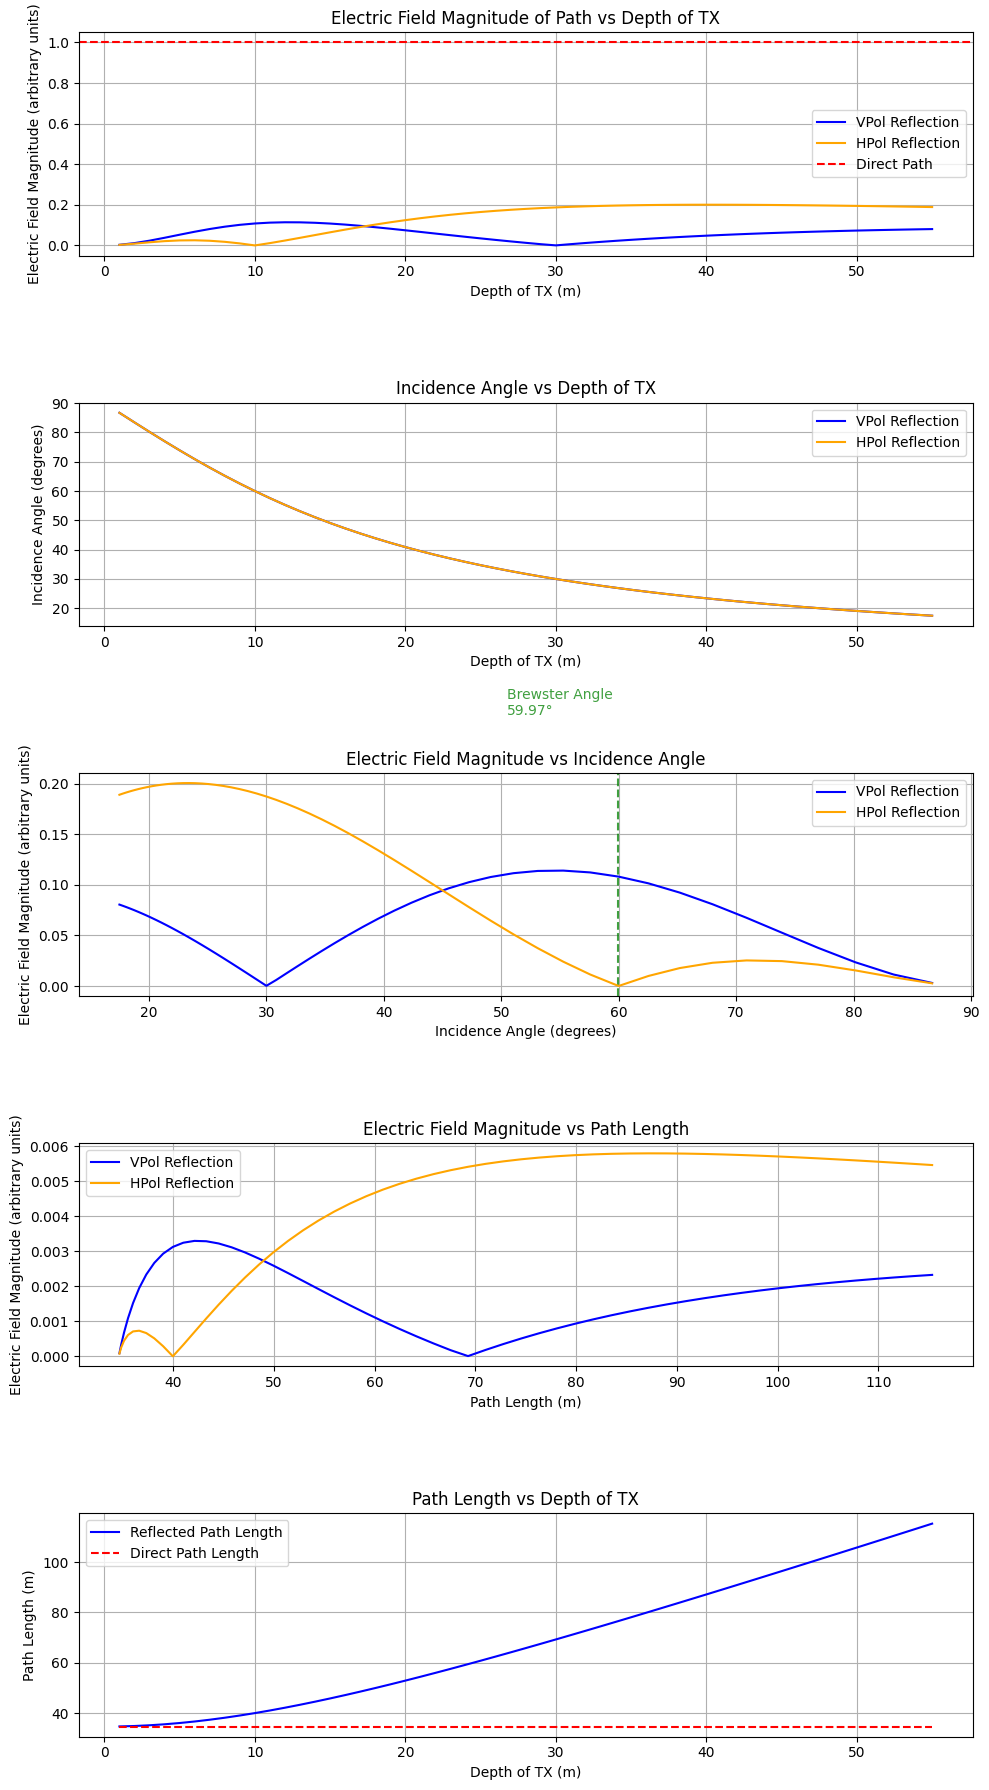

In [49]:
# make a plot with 5 subplots in one column. They should show E vs depth, E vs theta,  E vs path length, and path length vs depth
plt.figure(figsize=(10, 6))

# plot E vs depth
fig, axs = plt.subplots(5, 1, figsize=(10, 18))
axs[0].plot(depths, vpol_E_r_reflect, label='VPol Reflection', color='blue')
axs[0].plot(depths, hpol_E_r_reflect, label='HPol Reflection', color='orange')
axs[0].axhline(hpol_E_r_direct, color='red', linestyle='--', label='Direct Path')
axs[0].set_xlabel('Depth of TX (m)')
axs[0].set_ylabel('Electric Field Magnitude (arbitrary units)')
axs[0].set_title('Electric Field Magnitude of Path vs Depth of TX')
axs[0].legend()
axs[0].grid()

# plot theta in radians vs depth
vpol_theta_degrees = np.degrees(vpol_theta_r_reflected)
hpol_theta_degrees = np.degrees(hpol_theta_r_reflected)
axs[1].plot(depths, vpol_theta_degrees, label='VPol Reflection', color='blue')
axs[1].plot(depths, hpol_theta_degrees, label='HPol Reflection', color='orange')
axs[1].set_xlabel('Depth of TX (m)')
axs[1].set_ylabel('Incidence Angle (degrees)')
axs[1].set_title('Incidence Angle vs Depth of TX')
axs[1].legend()
axs[1].grid()

# plot E vs theta
# draw the brewster angle line
axs[2].axvline(brewster_angle_degrees, color='green', linestyle='--', alpha=0.75)
axs[2].plot(vpol_theta_degrees, vpol_E_r_reflect, label='VPol Reflection', color='blue')
axs[2].plot(hpol_theta_degrees, hpol_E_r_reflect, label='HPol Reflection', color='orange')

# label the brewster angle line
axs[2].text(brewster_angle_degrees - 9.5, 4*max(hpol_E_r_reflect)/3,
            f'Brewster Angle\n{brewster_angle_degrees:.2f}°', color='green', alpha=0.75)

axs[2].set_xlabel('Incidence Angle (degrees)')
axs[2].set_ylabel('Electric Field Magnitude (arbitrary units)')
axs[2].set_title('Electric Field Magnitude vs Incidence Angle')
axs[2].legend()
axs[2].grid()


# plot E vs path length
axs[3].plot(vpol_r_reflected, vpol_E_r_reflected, label='VPol Reflection', color='blue')
axs[3].plot(hpol_r_reflected, hpol_E_r_reflected, label='HPol Reflection', color='orange')
axs[3].set_xlabel('Path Length (m)')
axs[3].set_ylabel('Electric Field Magnitude (arbitrary units)')
axs[3].set_title('Electric Field Magnitude vs Path Length')
axs[3].legend()
axs[3].grid()

# plot path length vs depth
axs[4].plot(depths, vpol_r_reflected, label='Reflected Path Length', color='blue')
axs[4].plot(depths, [distance]*len(depths), label='Direct Path Length', color='red', linestyle='--')
axs[4].set_xlabel('Depth of TX (m)')
axs[4].set_ylabel('Path Length (m)')
axs[4].set_title('Path Length vs Depth of TX')
axs[4].legend()
axs[4].grid()

plt.tight_layout()
plt.savefig('My S12/1. Summary of Reflection Calculations.png', dpi=300, bbox_inches='tight')

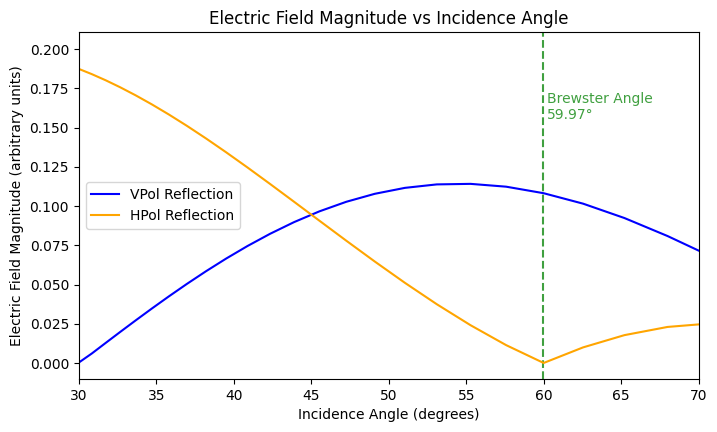

In [77]:
# # plot E vs theta
# # draw the brewster angle line
# axs[2].axvline(brewster_angle_degrees, color='green', linestyle='--', alpha=0.75)
# axs[2].plot(vpol_theta_degrees, vpol_E_r_reflect, label='VPol Reflection', color='blue')
# axs[2].plot(hpol_theta_degrees, hpol_E_r_reflect, label='HPol Reflection', color='orange')
#
# # label the brewster angle line
# axs[2].text(brewster_angle_degrees - 9.5, 4*max(hpol_E_r_reflect)/3,
#             f'Brewster Angle\n{brewster_angle_degrees:.2f}°', color='green', alpha=0.75)
#
# axs[2].set_xlabel('Incidence Angle (degrees)')
# axs[2].set_ylabel('Electric Field Magnitude (arbitrary units)')
# axs[2].set_title('Electric Field Magnitude vs Incidence Angle')
# axs[2].legend()
# axs[2].grid()

# plot E vs theta in degrees
plt.figure(figsize=(8, 4.5))
plt.axvline(brewster_angle_degrees, color='green', linestyle='--', alpha=0.75)
plt.plot(vpol_theta_degrees, vpol_E_r_reflect, label='VPol Reflection', color='blue')
plt.plot(hpol_theta_degrees, hpol_E_r_reflect, label='HPol Reflection', color='orange')
# label the brewster angle line
# plt.text(brewster_angle_degrees - 11, 4*max(hpol_E_r_reflect)/3,
#          f'Brewster Angle\n{brewster_angle_degrees:.2f}°', color='green', alpha=0.75)
plt.text(brewster_angle_degrees +0.25, max(hpol_E_r_reflect)-.045,
         f'Brewster Angle\n{brewster_angle_degrees:.2f}°', color='green', alpha=0.75)

plt.xlabel('Incidence Angle (degrees)')
plt.ylabel('Electric Field Magnitude (arbitrary units)')
# plt.ylim(0,.21)
plt.xlim(30,70)
plt.title('Electric Field Magnitude vs Incidence Angle')
plt.legend()
# plt.grid()
plt.savefig('My S12/0. Electric Field Magnitude vs Incidence Angle.png', dpi=300, bbox_inches='tight')
# export as a transparent png
plt.savefig('My S12/0. Electric Field Magnitude vs Incidence Angle transparent.png', dpi=300, bbox_inches='tight', transparent=True)

In [42]:
# vpol_E_r_reflect = E_r_reflect(reflected_path_lengths, thetas, pol='VPol')
# hpol_E_r_reflect = E_r_reflect(reflected_path_lengths, thetas, pol='HPol')
# vpol_E_r_reflect = np.array(vpol_E_r_reflect)
# hpol_E_r_reflect = np.array(hpol_E_r_reflect)
#
# vpol_E_r_direct = E_r_direct(distance)
# hpol_E_r_direct = E_r_direct(distance)
# vpol_E_r_direct = np.array(vpol_E_r_direct)
# hpol_E_r_direct = np.array(hpol_E_r_direct)

# print(shapes := (vpol_E_r_reflect, hpol_E_r_reflect, vpol_E_r_direct, hpol_E_r_direct))

In [43]:
# normalize the E_r values so that the direct path is 1
vpol_E_r_reflect = (1 / vpol_E_r_direct) * vpol_E_r_reflect
hpol_E_r_reflect = (1 / hpol_E_r_direct) * hpol_E_r_reflect
vpol_E_r_direct = vpol_E_r_direct / vpol_E_r_direct
hpol_E_r_direct = hpol_E_r_direct / hpol_E_r_direct

print(vpol_E_r_direct, hpol_E_r_direct)

1.0 1.0


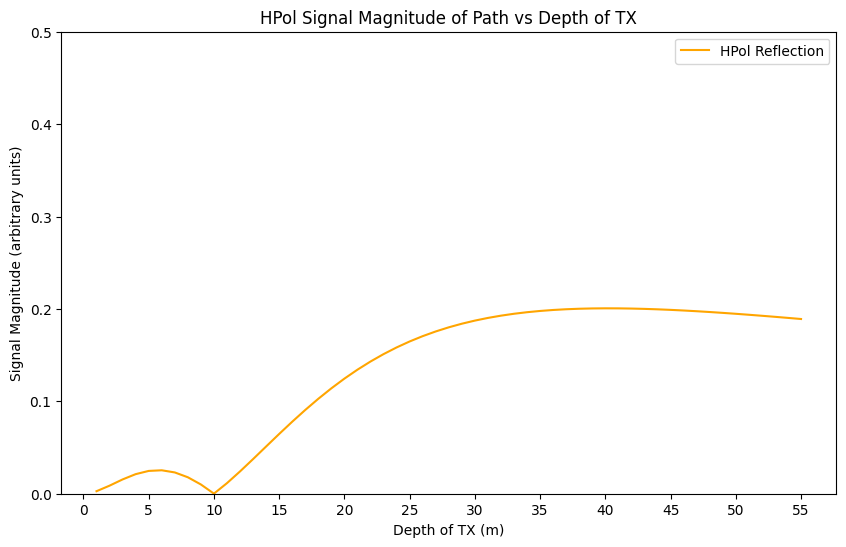

In [44]:
dir = 'My S12'
plt.figure(figsize=(10, 6))
# plt.axhline(hpol_E_r_direct, color='red', linestyle='--', label='Direct Path')
# plt.plot(depths, vpol_E_r_reflect, label='VPol Reflection', color='blue')
plt.plot(depths, hpol_E_r_reflect, label='HPol Reflection', color='orange')
plt.xlabel('Depth of TX (m)')
# x ticks every 5
plt.xticks(np.arange(0, max(depths)+1, 5))
plt.ylim(0,0.5)
plt.ylabel('Signal Magnitude (arbitrary units)')
plt.title('HPol Signal Magnitude of Path vs Depth of TX')
plt.legend()
plt.savefig(f'{dir}/2. Signal Magnitude vs Depth.png', dpi=300, bbox_inches='tight')
# plt.savefig(f'{dir}/test_Electric_Field_Magnitude_vs_Depth.png', dpi=300, bbox_inches='tight')

In [45]:
# calculate the ratio of reflected to direct path
vpol_ratio = vpol_E_r_reflect / vpol_E_r_direct
hpol_ratio = hpol_E_r_reflect / hpol_E_r_direct


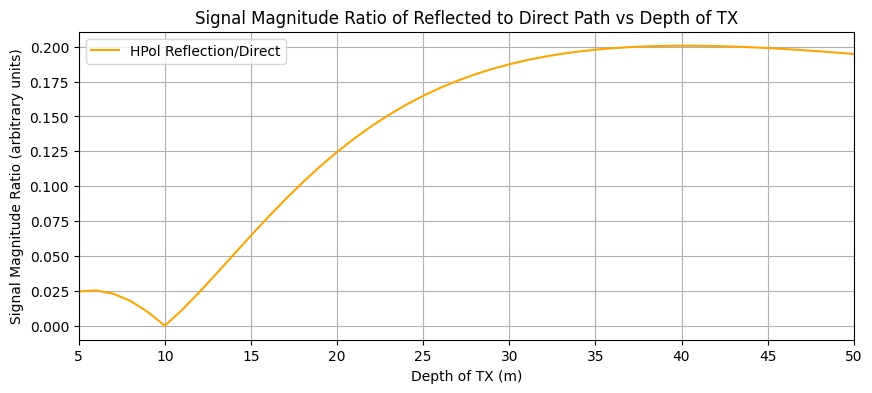

In [46]:
# plot the ratio vs depth
plt.figure(figsize=(10, 4))
# plt.plot(depths, vpol_ratio, label='VPol Reflection/Direct', color='blue')
plt.plot(depths, hpol_ratio, label='HPol Reflection/Direct', color='orange')
plt.xlabel('Depth of TX (m)')
# x ticks every 5
# plt.xticks(np.arange(0, max(depths)+1, 5))
plt.xlim(5,50)
# plt.ylim(0,0.2)
plt.ylabel('Signal Magnitude Ratio (arbitrary units)')
plt.title('Signal Magnitude Ratio of Reflected to Direct Path vs Depth of TX')
plt.legend()
plt.grid()
plt.savefig(f'{dir}/3. Signal Magnitude Ratio vs Depth cropped.png', dpi=300, bbox_inches='tight')